In [2]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'credit-card-customers:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F982921%2F1660340%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240604%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240604T101816Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D6613595a782582a06930355bba21017c15dfea2e7fc07c84ac94236b4bf18430714868d4f119103233ab47ef4abf0c9205b1746cf0afadf667a7c04461b1437549252c44143b9084574b13bc9990ff07cc0e45c66afb1b33817cb1bce4c29e7ff20bec96e051783bbee9dcbf0021d92ff1c89dbd8549a7a81bffddb8fed640fab2c08fbe3f4b58e9b5e82b640fdda2fd5a15c6562e6463123f1e962fd051464011573cc052b1c15e0b5ae4f5441c56928b0e495aca7a709456a91c8500ef6197d68d7f8c3c1e89e77ba23da8a8afc39bf870f60356df5083bccf73e7ec4ed495a3100b67aff957cd6898e19984b27896b89294bf6755277b5c6ff6b93996b0b0'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 387771 bytes downloaded
Downloaded and uncompressed: credit-card-customers
Data source import complete.


<h2 style='text-align:center;font-family:Comic Sans MS;font-size:40px;background-color:purple;border:20px;color:white'>Credit Card customers - Predict Churning customers<h2>
    
![](https://thumbs.gfycat.com/EagerAlarmedKillifish-size_restricted.gif)

<h2 style='text-align:center;font-family:Comic Sans MS;font-size:25px;background-color:purple;border:20px;color:white'>Table of Contents<h2>


## 1. Introducion
## 2. Data ID
## 3. Libraries
## 4. File Path
## 5. Preprocessing and Data Analysis
## 6. Machine learning models
## 7. Conclusion
    
# Introducion
    
**Problem Statement:**
A manager at the bank is disturbed with more and more customers leaving their credit card services. They would really appreciate if one could predict for them who is gonna get churned so they can proactively go to the customer to provide them better services and turn customers' decisions in the opposite direction

**Breakdown of the Problem Statement:**

* Supervised machine learning classification problem.
* The target value will be `Attrition_Flag`.
    
**Aim of the NoteBook:**
    
Create a model to predict what customer has a high risk of leaving the bank's credit card services.
    
![](https://media1.giphy.com/media/gj6va0A4XtMBqRmfsH/giphy.gif)

# Data Id 📋
    
 This dataset is named [Credit Card customers](https://www.kaggle.com/sakshigoyal7/credit-card-customers). The dataset contains a set of **10,127 records** under **23 attributes**:


| Column Name                         | Description                                                    |
|------------------                   |----------------------------------------------------------------|
| `CLIENTNUM`                         | Client number ID                                               |
| `Attrition_Flag`                    | Customer activity, Attrited or existing                        |
| `Customer_Age`                      | Customer's Age in Years                                        |
| `Gender`                            | Customer's gender, male or female                              |
| `Dependent_count`                   | Number of dependents                                           |
| `Education_Level`                   | Educational Qualification of the account holder                |
| `Marital_Status`                    | Married, Single, Divorced, Unknown                             |
| `Income_Category`                   | Annual Income Category of the account holder                   |
| `Card_Category`                     | Type of Card (Blue, Silver, Gold, Platinum)                    |
| `Months_on_book`                    | Period of relationship with bank                               |
| `Total_Relationship_Count`          | Total number of products held by the customer                  |  
| `Months_Inactive_12_mon`            | Number of months inactive in the last 12 months                |
| `Contacts_Count_12_mon`             | Number of Contacts in the last 12 months                       |
| `Credit_Limit`                      | Credit Limit on the Credit Card                                |
| `Total_Revolving_Bal`               | Total Revolving Balance on the Credit Card                     |
| `Avg_Open_To_Buy`                   | Open to Buy Credit Line (Average of last 12 months)            |
| `Total_Amt_Chng_Q4_Q1`              | Change in Transaction Amount (Q4 over Q1)                      |
| `Total_Trans_Amt`                   | Total Transaction Amount (Last 12 months)                      |  
| `Total_Trans_Ct`                    | Total Transaction Count (Last 12 months)                       |
| `Total_Ct_Chng_Q4_Q1`               | Change in Transaction Count (Q4 over Q1)                       |
| `Avg_Utilization_Ratio`             | Average Card Utilization Ratio                                 |
| `Naive_Bayes_Classifier_Attrition_..._mon_1` | Naive Bayes |
| `Naive_Bayes_Classifier_Attrition_..._mon_1` | Naive Bayes |

    
    



# Libraries 📚

In [4]:
import os #paths to file
import numpy as np # linear algebra
import pandas as pd # data processing
import warnings# warning filter


#ploting libraries
import matplotlib.pyplot as plt
import seaborn as sns

#feature engineering
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection  import cross_val_score as CVS
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score


#ML models
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

#default theme
sns.set(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=False, rc=None)

#warning hadle
warnings.filterwarnings("always")
warnings.filterwarnings("ignore")

# File path 📂

In [5]:
#list all files under the input directory
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/credit-card-customers/BankChurners.csv


In [6]:
path = "/kaggle/input/credit-card-customers/BankChurners.csv"

# Preprocessing and Data Analysis 💻

## first look at the data

In [8]:
df = pd.read_csv(path)
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


we already have 3 columns that are useless to our analysis:
1. **CLIENTNUM** - Client ID is useless for analysis.
2. **Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1** -The Data provider advised to ignore this column.
3. **Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2** - same reason as the previus columns.


In [10]:
credit_df =  df.copy()
credit_df = credit_df.iloc[:,1:21]
credit_df.head(2)

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105


**size of our data:**

In [13]:
print(f"Dataset (row, col): {credit_df.shape}")

Dataset (row, col): (10127, 20)


## Dataset info

In [17]:
#column information
credit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Attrition_Flag            10127 non-null  object 
 1   Customer_Age              10127 non-null  int64  
 2   Gender                    10127 non-null  object 
 3   Dependent_count           10127 non-null  int64  
 4   Education_Level           10127 non-null  object 
 5   Marital_Status            10127 non-null  object 
 6   Income_Category           10127 non-null  object 
 7   Card_Category             10127 non-null  object 
 8   Months_on_book            10127 non-null  int64  
 9   Total_Relationship_Count  10127 non-null  int64  
 10  Months_Inactive_12_mon    10127 non-null  int64  
 11  Contacts_Count_12_mon     10127 non-null  int64  
 12  Credit_Limit              10127 non-null  float64
 13  Total_Revolving_Bal       10127 non-null  int64  
 14  Avg_Op

In [18]:
#summary statistics
credit_df.describe()

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
count,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,46.325960,2.346203,35.928409,3.812580,2.341167,2.455317,8631.953698,1162.814061,7469.139637,0.759941,4404.086304,64.858695,0.712222,0.274894
std,8.016814,1.298908,7.986416,1.554408,1.010622,1.106225,9088.776650,814.987335,9090.685324,0.219207,3397.129254,23.472570,0.238086,0.275691
min,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000,0.000000,0.000000
25%,41.000000,1.000000,31.000000,3.000000,2.000000,2.000000,2555.000000,359.000000,1324.500000,0.631000,2155.500000,45.000000,0.582000,0.023000
50%,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000,4549.000000,1276.000000,3474.000000,0.736000,3899.000000,67.000000,0.702000,0.176000
75%,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000,11067.500000,1784.000000,9859.000000,0.859000,4741.000000,81.000000,0.818000,0.503000
max,73.000000,5.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,2517.000000,34516.000000,3.397000,18484.000000,139.000000,3.714000,0.999000


### unique values for categorical columns

In [22]:
#list of all the numeric columns
num = credit_df.select_dtypes('number').columns.to_list()
print(num)
#list of all the categoric columns
cat = credit_df.select_dtypes('object').columns.to_list()
print(cat)

['Customer_Age', 'Dependent_count', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio']
['Attrition_Flag', 'Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']


In [23]:
for i in cat:
    print(f"{i}:\n {credit_df[i].unique()}\n\n")

Attrition_Flag:
 ['Existing Customer' 'Attrited Customer']


Gender:
 ['M' 'F']


Education_Level:
 ['High School' 'Graduate' 'Uneducated' 'Unknown' 'College' 'Post-Graduate'
 'Doctorate']


Marital_Status:
 ['Married' 'Single' 'Unknown' 'Divorced']


Income_Category:
 ['$60K - $80K' 'Less than $40K' '$80K - $120K' '$40K - $60K' '$120K +'
 'Unknown']


Card_Category:
 ['Blue' 'Gold' 'Silver' 'Platinum']




### categorical variable counts (%):
Checking how the categorical data is distributed.

In [25]:
[round(credit_df[category].value_counts()/credit_df.shape[0]*100,2) for category in cat[:]]

[Attrition_Flag
 Existing Customer    83.93
 Attrited Customer    16.07
 Name: count, dtype: float64,
 Gender
 F    52.91
 M    47.09
 Name: count, dtype: float64,
 Education_Level
 Graduate         30.89
 High School      19.88
 Unknown          15.00
 Uneducated       14.68
 College          10.00
 Post-Graduate     5.10
 Doctorate         4.45
 Name: count, dtype: float64,
 Marital_Status
 Married     46.28
 Single      38.94
 Unknown      7.40
 Divorced     7.39
 Name: count, dtype: float64,
 Income_Category
 Less than $40K    35.16
 $40K - $60K       17.68
 $80K - $120K      15.16
 $60K - $80K       13.84
 Unknown           10.98
 $120K +            7.18
 Name: count, dtype: float64,
 Card_Category
 Blue        93.18
 Silver       5.48
 Gold         1.15
 Platinum     0.20
 Name: count, dtype: float64]

## 📝 Note
**We have no missing values but some of our categories have an unkown values therefor there is a need to handle those unknowns**

## Missing values 🚫

The `Unknown` are in categorical column, therefore we will substitute the current values with `None`.

In [26]:
credit_df = credit_df.replace({'Unknown': None})
credit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Attrition_Flag            10127 non-null  object 
 1   Customer_Age              10127 non-null  int64  
 2   Gender                    10127 non-null  object 
 3   Dependent_count           10127 non-null  int64  
 4   Education_Level           8608 non-null   object 
 5   Marital_Status            9378 non-null   object 
 6   Income_Category           9015 non-null   object 
 7   Card_Category             10127 non-null  object 
 8   Months_on_book            10127 non-null  int64  
 9   Total_Relationship_Count  10127 non-null  int64  
 10  Months_Inactive_12_mon    10127 non-null  int64  
 11  Contacts_Count_12_mon     10127 non-null  int64  
 12  Credit_Limit              10127 non-null  float64
 13  Total_Revolving_Bal       10127 non-null  int64  
 14  Avg_Op

Now we will analize the missing values in both ways:
* by numbers
* by %

In [27]:
print("Countwise:\n\n",credit_df.isnull().sum().sort_values(ascending=False),"Percentage (%):\n\n",credit_df.isnull().sum()/credit_df.shape[0] *100)

Countwise:

 Education_Level             1519
Income_Category             1112
Marital_Status               749
Attrition_Flag                 0
Credit_Limit                   0
Total_Ct_Chng_Q4_Q1            0
Total_Trans_Ct                 0
Total_Trans_Amt                0
Total_Amt_Chng_Q4_Q1           0
Avg_Open_To_Buy                0
Total_Revolving_Bal            0
Months_Inactive_12_mon         0
Contacts_Count_12_mon          0
Customer_Age                   0
Total_Relationship_Count       0
Months_on_book                 0
Card_Category                  0
Dependent_count                0
Gender                         0
Avg_Utilization_Ratio          0
dtype: int64 Percentage (%):

 Attrition_Flag               0.000000
Customer_Age                 0.000000
Gender                       0.000000
Dependent_count              0.000000
Education_Level             14.999506
Marital_Status               7.396070
Income_Category             10.980547
Card_Category                0

`Education_Level`,`Income_Category`,`Income_Category` are categorical columns, therefore we will impute missing values with the mode value.

In [29]:
credit_df['Education_Level'] = credit_df['Education_Level'].fillna(
credit_df['Education_Level'].dropna().mode().values[0])

credit_df['Income_Category'] = credit_df['Income_Category'].fillna(
credit_df['Income_Category'].dropna().mode().values[0])

credit_df['Marital_Status'] = credit_df['Marital_Status'].fillna(
credit_df['Marital_Status'].dropna().mode().values[0])

[round(credit_df[category].value_counts()/credit_df.shape[0]*100,2) for category in cat[:]]

[Attrition_Flag
 Existing Customer    83.93
 Attrited Customer    16.07
 Name: count, dtype: float64,
 Gender
 F    52.91
 M    47.09
 Name: count, dtype: float64,
 Education_Level
 Graduate         45.89
 High School      19.88
 Uneducated       14.68
 College          10.00
 Post-Graduate     5.10
 Doctorate         4.45
 Name: count, dtype: float64,
 Marital_Status
 Married     53.68
 Single      38.94
 Divorced     7.39
 Name: count, dtype: float64,
 Income_Category
 Less than $40K    46.14
 $40K - $60K       17.68
 $80K - $120K      15.16
 $60K - $80K       13.84
 $120K +            7.18
 Name: count, dtype: float64,
 Card_Category
 Blue        93.18
 Silver       5.48
 Gold         1.15
 Platinum     0.20
 Name: count, dtype: float64]

In [31]:
credit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Attrition_Flag            10127 non-null  object 
 1   Customer_Age              10127 non-null  int64  
 2   Gender                    10127 non-null  object 
 3   Dependent_count           10127 non-null  int64  
 4   Education_Level           10127 non-null  object 
 5   Marital_Status            10127 non-null  object 
 6   Income_Category           10127 non-null  object 
 7   Card_Category             10127 non-null  object 
 8   Months_on_book            10127 non-null  int64  
 9   Total_Relationship_Count  10127 non-null  int64  
 10  Months_Inactive_12_mon    10127 non-null  int64  
 11  Contacts_Count_12_mon     10127 non-null  int64  
 12  Credit_Limit              10127 non-null  float64
 13  Total_Revolving_Bal       10127 non-null  int64  
 14  Avg_Op

now that we filled unknown data we can start exploring the data.

## Data Exploration

![](https://media3.giphy.com/media/HUplkVCPY7jTW/giphy.webp?cid=ecf05e47ib8qvllx0nhxz2vrqs13vwrnqqgd9l908x8oepc7&rid=giphy.webp)

Let's take alook at 2 examples for further clarification of the data with examples:

## 📝 Note
those meanings are made up to match the profile of the client according to the client's profile data.

In [33]:
credit_df.iloc[10113,:]

Attrition_Flag              Attrited Customer
Customer_Age                               27
Gender                                      M
Dependent_count                             0
Education_Level                   High School
Marital_Status                       Divorced
Income_Category                   $60K - $80K
Card_Category                            Blue
Months_on_book                             36
Total_Relationship_Count                    2
Months_Inactive_12_mon                      3
Contacts_Count_12_mon                       2
Credit_Limit                          13303.0
Total_Revolving_Bal                      2517
Avg_Open_To_Buy                       10786.0
Total_Amt_Chng_Q4_Q1                    0.929
Total_Trans_Amt                         10219
Total_Trans_Ct                             85
Total_Ct_Chng_Q4_Q1                     0.809
Avg_Utilization_Ratio                   0.189
Name: 10113, dtype: object

| Column Name                | Value               | Meaning Example|
|----------------------------|---------------------|-------------|
| `Attrition_Flag`           | `Attrited Customer` | The client already left the credit card service        |
| `Customer_Age`             | `27`                | Young adult, 27 years old            |
| `Gender`                   | `M`                 | Male |
| `Dependent_count`          | `0`                 | Has no little children or old parents to financialy take care of |
| `Education_Level`          | `High School`       | Finished high school, no academic degree            |
| `Marital_Status`           | `Divorced`          | Might have financial issues with ex wife            |
| `Income_Category`          | `60K - 80K`         | Has an anual income of 65,000 dollars           |
| `Card_Category`            | `Blue`              | Had the blue credit card  |
| `Months_on_book`           | `36`                | Had the credit service for 3 years            |
| `Total_Relationship_Count` |  `2`                | Had an account in the bank and the credit card service (2 Relationships)|
| `Months_Inactive_12_mon`   |  `3`                | The credit card was inactive for 3 months total (Average)      |
| `Contacts_Count_12_mon`    |  `2`                | The client reached the bank one time and the same vice versa |
| `Credit_Limit`             |  `13303`            | Monthly credit limit of 13,303 dollars        |
| `Total_Revolving_Bal`      |   `2517`            | In the period of the card's service the client had a revolving balance that sumed up to 2,517 dollars            |
| `Avg_Open_To_Buy`          | `10786`             | The amount left to use in the past 12 months is 10,786 dollars |
| `Total_Amt_Chng_Q4_Q1`     |  `0.929`            | The amount spent in the 4th quarter was slightly lower then the 1st Quarter      |
| `Total_Trans_Amt`          |  `10219`            | The transactions made are 10,219 dollars in total            |
| `Total_Trans_Ct`           |  `85`               | The transactions are 85 in total            |
| `Total_Ct_Chng_Q4_Q1`      |  `0.809`            | The transactions rate in the 4th Quarter is lower then the 1st Quarter    |
| `Avg_Utilization_Ratio`    |   `0.189`           | Had an 18.9% card usage in average (credit limit/revolving balnce)  |


In [38]:
credit_df.iloc[3,:]

Attrition_Flag              Existing Customer
Customer_Age                               40
Gender                                      F
Dependent_count                             4
Education_Level                   High School
Marital_Status                        Married
Income_Category                Less than $40K
Card_Category                            Blue
Months_on_book                             34
Total_Relationship_Count                    3
Months_Inactive_12_mon                      4
Contacts_Count_12_mon                       1
Credit_Limit                           3313.0
Total_Revolving_Bal                      2517
Avg_Open_To_Buy                         796.0
Total_Amt_Chng_Q4_Q1                    1.405
Total_Trans_Amt                          1171
Total_Trans_Ct                             20
Total_Ct_Chng_Q4_Q1                     2.333
Avg_Utilization_Ratio                    0.76
Name: 3, dtype: object

| Column Name                | Value               | Meaning Example|
|----------------------------|---------------------|-------------|
| `Attrition_Flag`           | `Existing Customer` | The client already left the credit card service        |
| `Customer_Age`             | `40`                | Middle aged, 40 years old            |
| `Gender`                   | `F`                 | Female |
| `Dependent_count`          | `4`                 | Has 3 little children and an old mother to financialy take care of |
| `Education_Level`          | `High School`       | Finished high school, no academic degree            |
| `Marital_Status`           | `Married`           | Has a husband that might help financially            |
| `Income_Category`          | `Less than 40K`     | Has an anual income of 37,000 dollars           |
| `Card_Category`            | `Blue`              | Had the blue credit card  |
| `Months_on_book`           | `34`                | Had the credit service for 2 years and 10 months so far |
| `Total_Relationship_Count` | `3`                 | Had an account in the bank and the credit card service, and a deposit account for her children (3 Relationships)|
| `Months_Inactive_12_mon`   | `4`                 | The credit card was inactive for 4 months total (Average)      |
| `Contacts_Count_12_mon`    | `1`                 | The client reached the bank once |
| `Credit_Limit`             | `3313`              | Monthly credit limit of 3,313 dollars        |
| `Total_Revolving_Bal`      | `2517`              | In the period of the card's service the client had a revolving balance that sumed up to 2,517 dollars            |
| `Avg_Open_To_Buy`          | `796`               | The amount left to use in the past 12 months is 796 dollars |
| `Total_Amt_Chng_Q4_Q1`     | `1.405`             | The amount spent in the 4th quarter was around 40% higher then the 1st Quarter      |
| `Total_Trans_Amt`          | `1171`              | The transactions made are 1,171 dollars in total            |
| `Total_Trans_Ct`           | `20`                | The transactions are 20 in total            |
| `Total_Ct_Chng_Q4_Q1`      | `2.333`             | The transactions rate in the 4th Quarter is more then twice then the 1st Quarter    |
| `Avg_Utilization_Ratio`    | `0.760`             | Had an 76% card usage in average (credit limit/revolving balnce)  |

As written see above a comparison can be made berween those profiles but the goal of those examples are to explain clearly the attributes of the data.

## Data Visualization 📊

### Univariate Plots

For plotting with percentage we will create a function:

**`precent_maker`** function will plot percentages on the bar graphs if you have a normal plot. It takes the actual graph and feature as a parameter.

In [39]:
def precent_maker(plot, feature):
    total = len(feature)
    for p in plot.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 12)
    plt.show()

### For starters we will create the plot for our `Attrition_Flag` column:

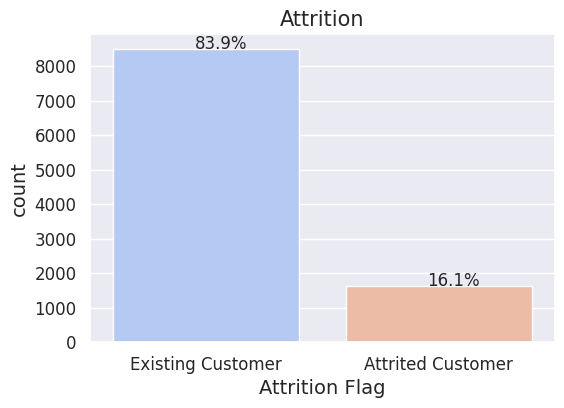

In [40]:
plt.figure(figsize=(6,4))
ax = sns.countplot(x='Attrition_Flag' , data=credit_df ,palette='coolwarm')
plt.xticks(size = 12)
plt.xlabel('Attrition Flag', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.yticks(size = 12)
plt.title("Attrition", size = 15)
precent_maker(ax, credit_df.Attrition_Flag)

### Now for the other categoric variables:

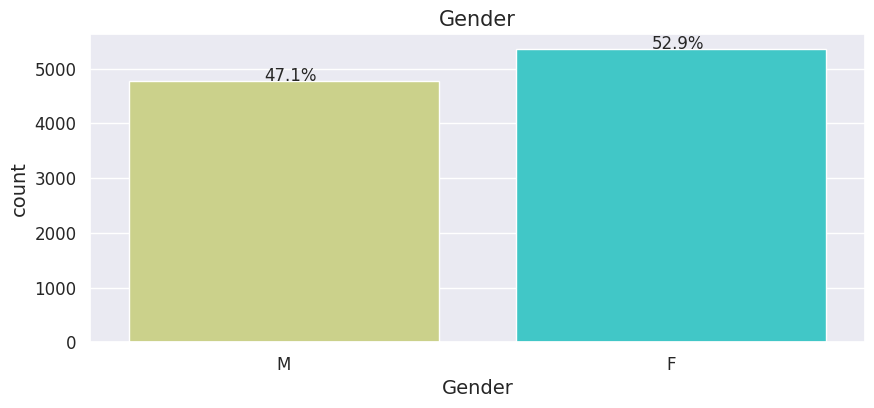

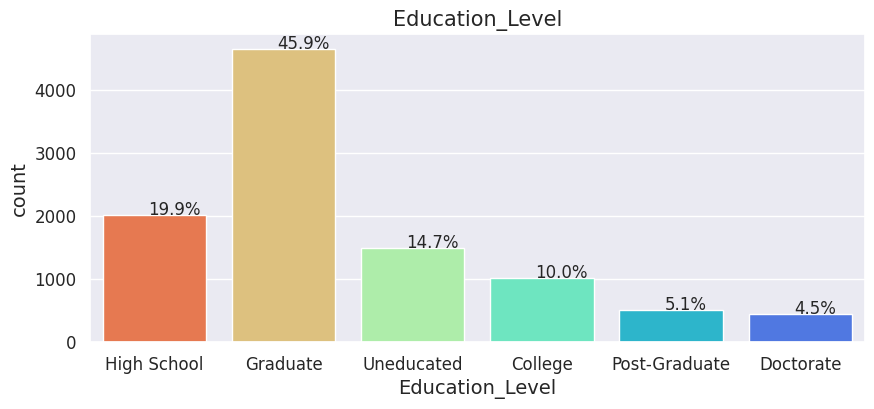

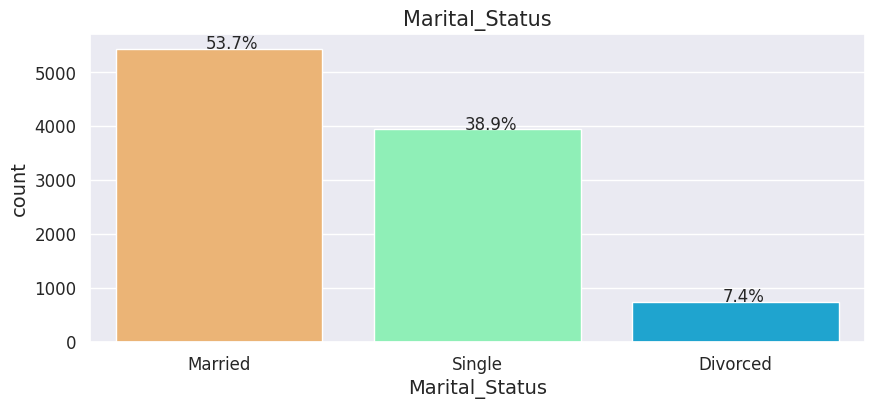

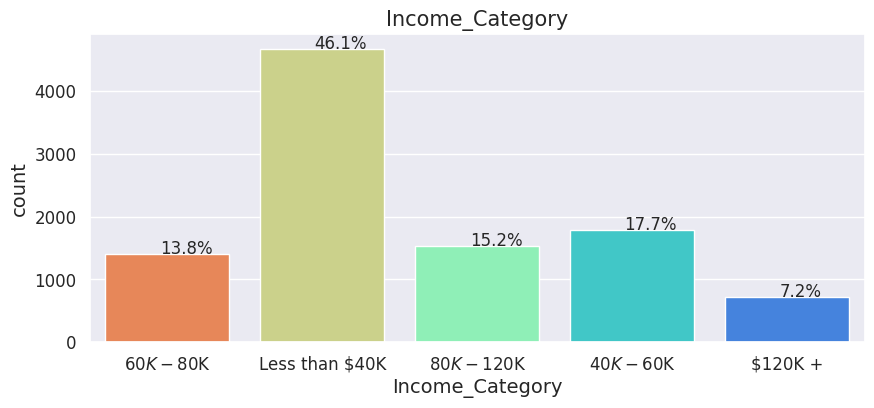

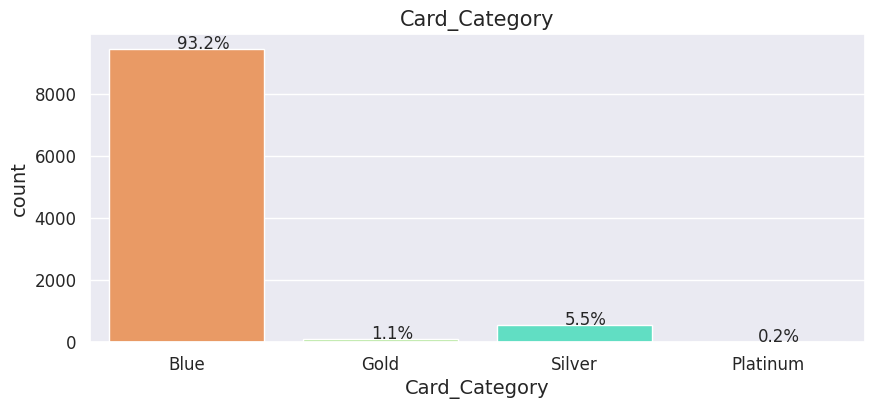

In [41]:
for i in cat[1:]:
    plt.figure(figsize=(10,4))
    ax = sns.countplot(x=i , data=credit_df ,palette='rainbow_r')
    plt.xticks(size = 12)
    plt.xlabel(i, fontsize=14)
    plt.ylabel('count', fontsize=14)
    plt.yticks(size = 12)
    plt.title(i, size = 15)
    precent_maker(ax, credit_df[i])

### Category unvariate analysis:

* **`Gender`** - most of the clients (52.9%) are Females.
* **`Education_Level`** - most of the clients (55.5%) are Graduates or have a higher degree.
* **`Marital_Status`** - most of the clients (53.7%) are Married.
* **`Inocome_Category`** - most of the clients (63.8%) Have an anual income of 60K or less.
* **`Gender`** - most of the clients (93.2%) Have a Blue credit card.


## multivariate plots for categorical variables


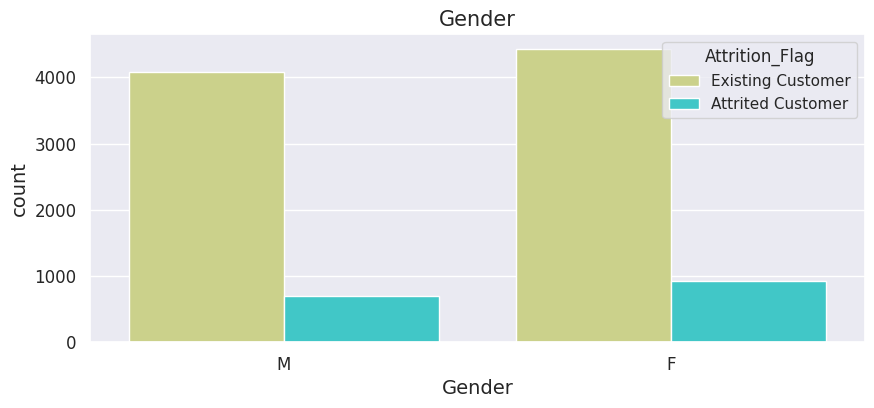

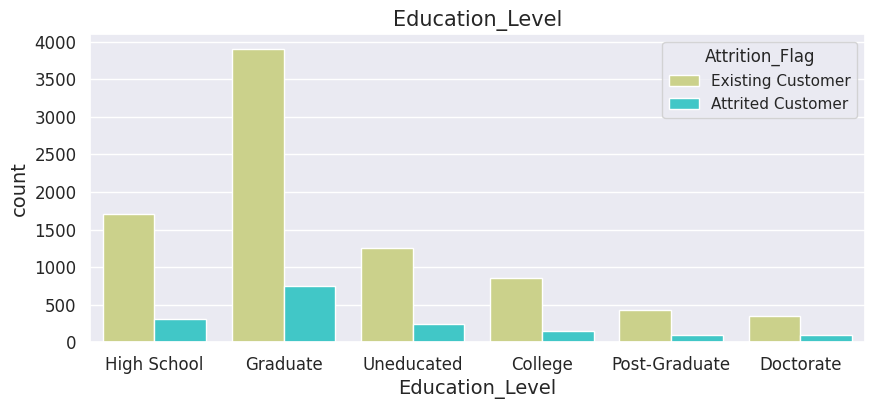

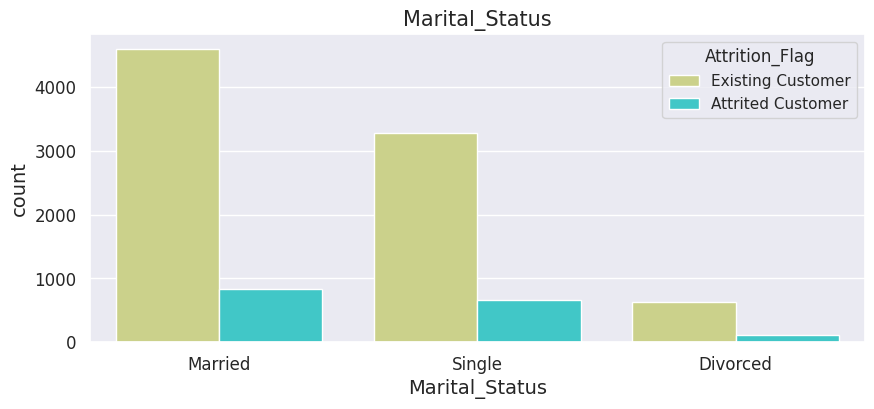

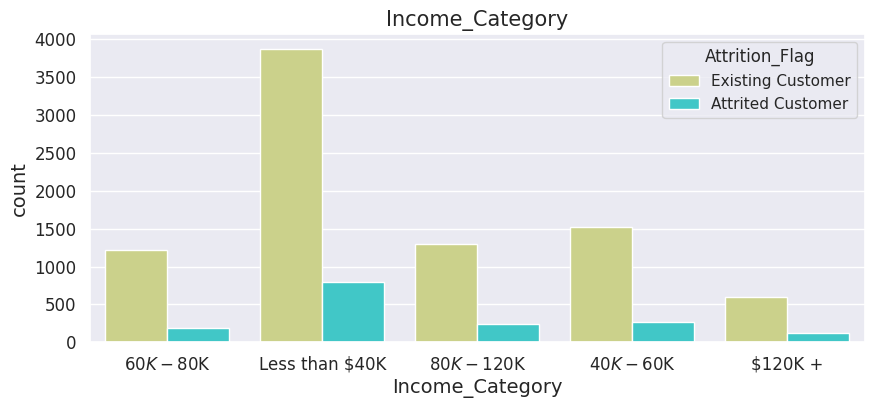

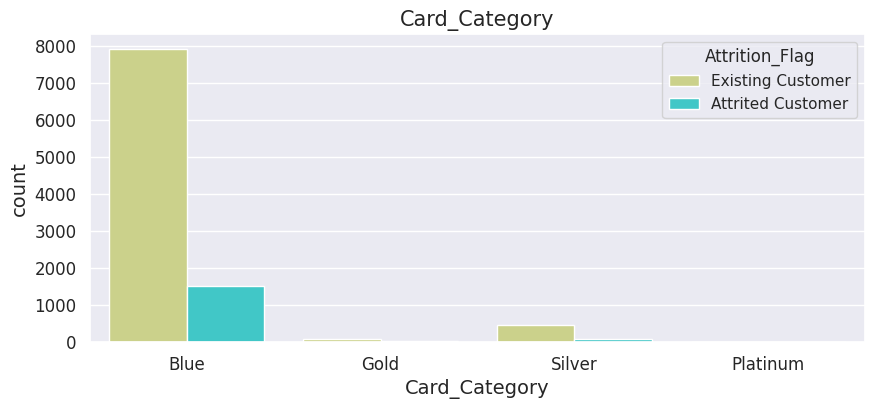

In [42]:
for i in cat[1:]:
    plt.figure(figsize=(10,4))
    ax = sns.countplot(x=i , data=credit_df, hue = 'Attrition_Flag' ,palette='rainbow_r')
    plt.xticks(size = 12)
    plt.xlabel(i, fontsize=14)
    plt.ylabel('count', fontsize=14)
    plt.yticks(size = 12)
    plt.title(i, size = 15)
    plt.show()

In [43]:
func = lambda x: round(100*x.count()/df.shape[0],2)
[ pd.pivot_table(credit_df, index=[col,"Attrition_Flag"], aggfunc = {col:func}) for col in cat[1:]]


[                          Gender
 Gender Attrition_Flag           
 F      Attrited Customer    9.18
        Existing Customer   43.72
 M      Attrited Customer    6.88
        Existing Customer   40.21,
                                    Education_Level
 Education_Level Attrition_Flag                    
 College         Attrited Customer             1.52
                 Existing Customer             8.48
 Doctorate       Attrited Customer             0.94
                 Existing Customer             3.52
 Graduate        Attrited Customer             7.34
                 Existing Customer            38.55
 High School     Attrited Customer             3.02
                 Existing Customer            16.86
 Post-Graduate   Attrited Customer             0.91
                 Existing Customer             4.19
 Uneducated      Attrited Customer             2.34
                 Existing Customer            12.34,
                                   Marital_Status
 Marital_Status 

### analysis of categorical data with Attrition hue

We know that the general attrition rate is 16.1% so our aim is to find values that are higher then that in the sub gruops of our categorical variables.

* **`Gender`** - Female clients have a slightly higher (17.35%) Atrrition rate, not very significant.
* **`Education_Level`** - Post-Graduate clients have a slightly higher (17.84%) Atrrition rate ,Doctorate clients have a higher (21.08%) Atrrition rate.
* **`Marital_Status`** - no major diffrence in attrition rates overall (16.95% attrition rate in the single group is not very significant).
* **`Inocome_Category`** - clients with 120000 dollar or higher annual income have a slightly higher (17.29%) Atrrition rate, not very significant.
* **`Card_Category`** - Gold card clients have a slightly higher (18.26%) Atrrition rate ,Platinum card clients have a higher (25%) Atrrition rate.

In conclusion for the categorical values we see that only 2 categories stayed relevant: `Education_Level` and `Card_Category`,
but because the variables in the gruops that had an increase of attrition from the original general attrition rate are very small compared to the entire data their impact might be very small.



### Now for the numeric variables:

First of all we wiil make boxplots for this analysis:

![](https://miro.medium.com/max/1050/1*NRlqiZGQdsIyAu0KzP7LaQ.png)

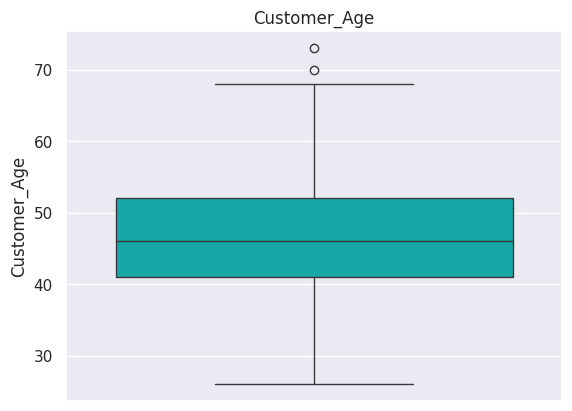

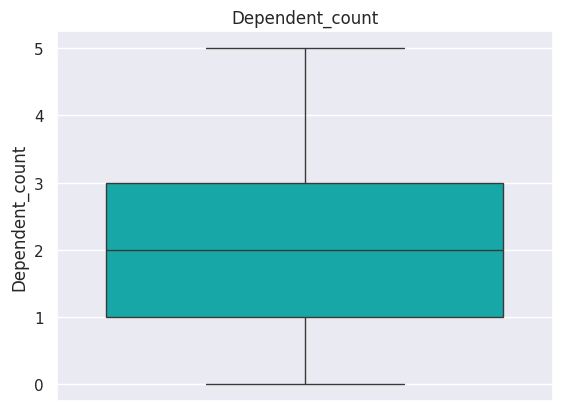

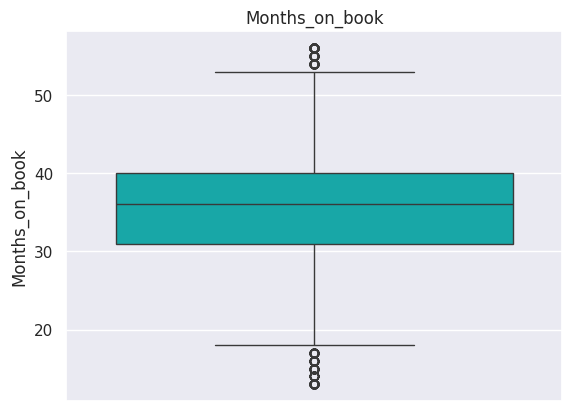

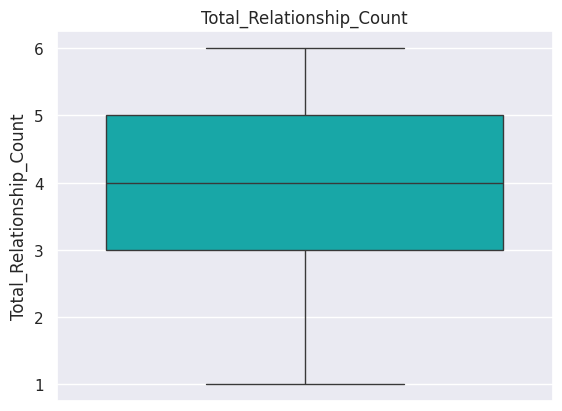

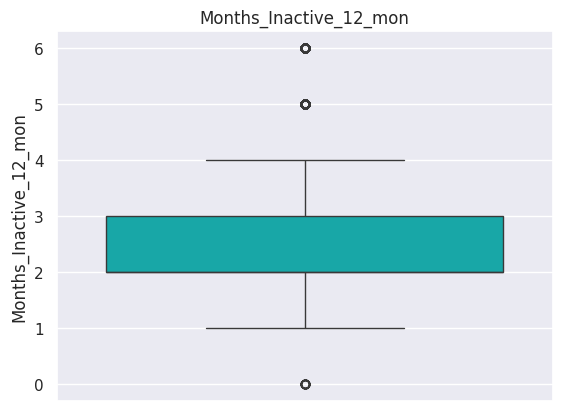

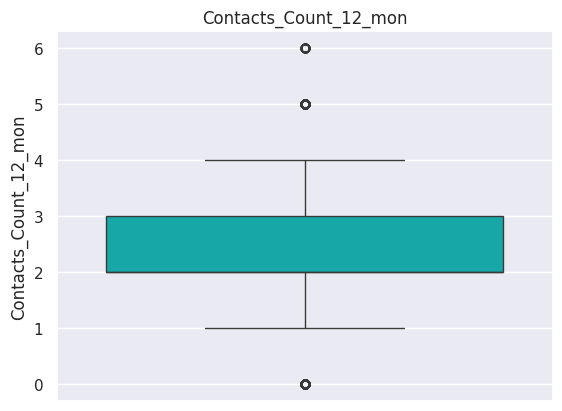

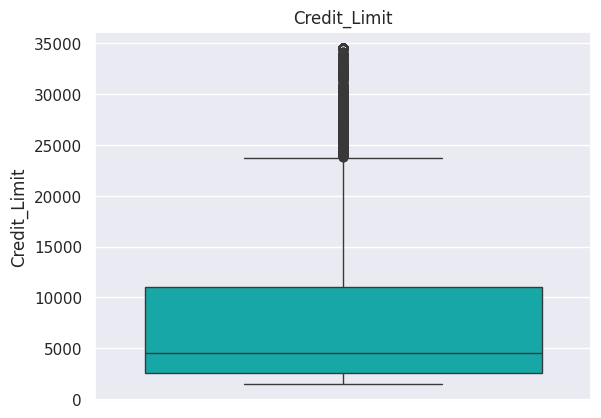

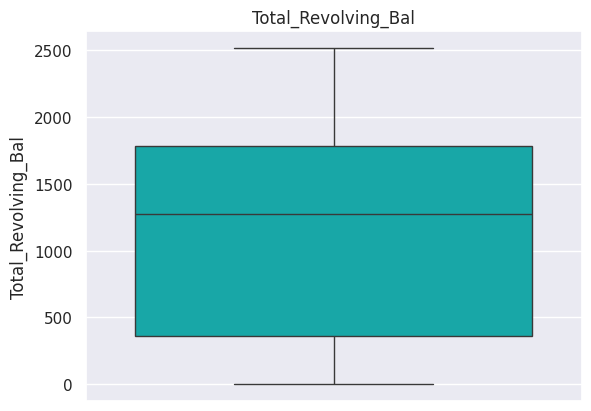

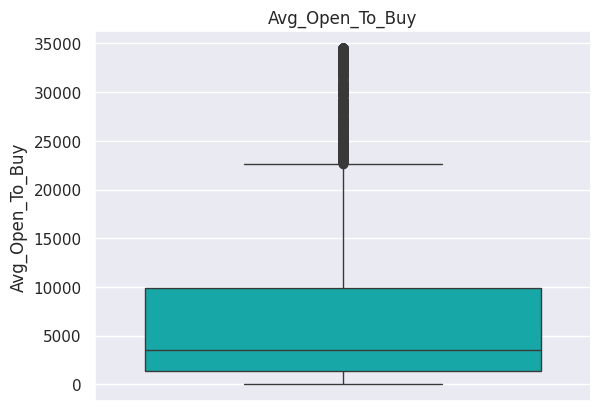

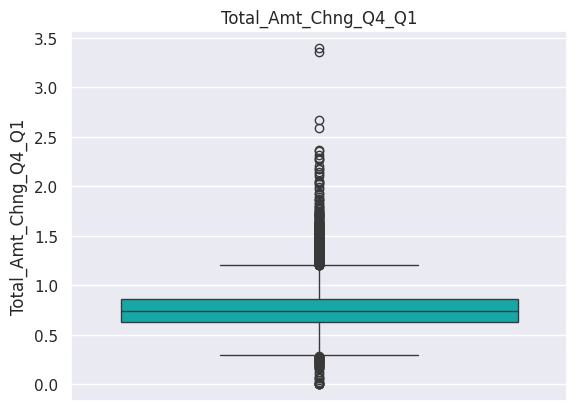

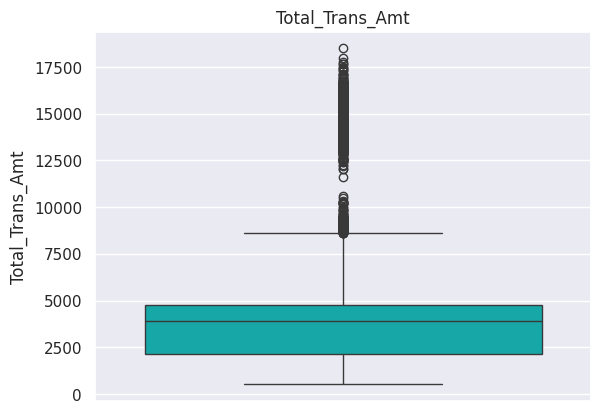

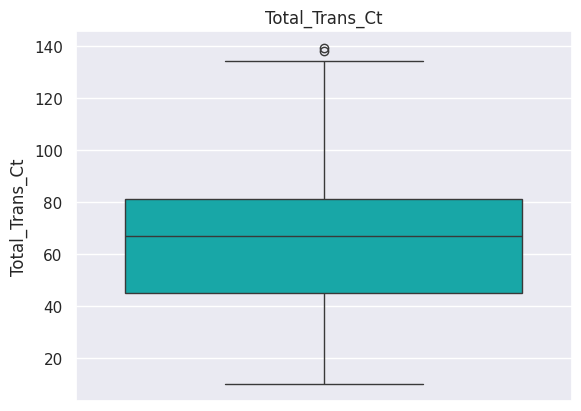

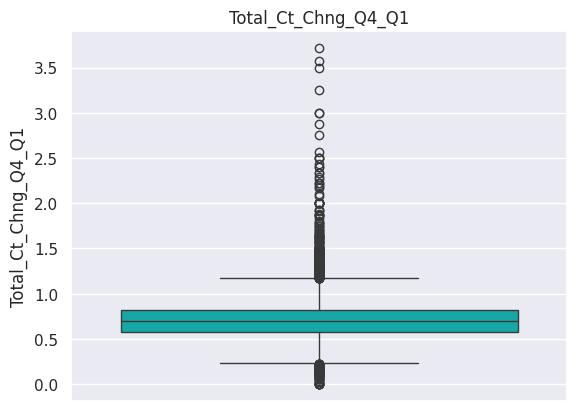

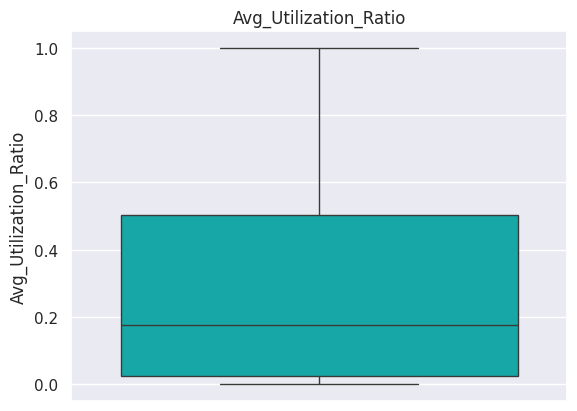

In [45]:
for numeric in credit_df[num]:
# I personally prefer a vertical view and a cyan color
    sns.boxplot(data=credit_df[numeric],orient="v", color = 'c')
    plt.title(numeric)
    plt.show()


### Numeric variables analysis:
From those box plots we have a general idea for the distributions and important statsitical analysis of each numeric column (the numbers below are approximations):

* **`Customer_Age`** - The age data is distibuted between 40 and 52 in the IQR with a few outlier point over 70 years old.
* **`Dependent_count	`** - IQR is between 1 and 3 (median - 2) max amount is 5 and min is 0.
* **`Months_on_book`** - IQR is between 30 and 40 (median - 35) there are outliers above 55 and below 18.
* **`Total_Relationship_Count`** - IQR is between 3 and 5 (median - 4) max amount is 6 and min is 1.
* **`Months_Inactive_12_mon`** - IQR is between 2 and 3 there are outliers above 4(5,6) and below 1 (0).
* **`Contacts_Count_12_mon`** - IQR is between 2 and 3 there are outliers above 4(5,6) and below 1 (0).
* **`Credit_Limit`** - IQR is between 2500 and 11000 (median - 5000) there are outliers above 24000 and below 1000.
* **`Total_Revolving_Bal`** - IQR is between 400 and 1800 (median - 1300) max amount is 2500 and min is 0.
* **`Avg_Open_To_Buy`** - IQR is between 1000 and 10000 (median - 3500) there are outliers above 22500.
* **`Total_Amt_Chng_Q4_Q1`** - IQR is between 0.6 and 0.9 (median - 0.7) there are outliers above 1.2 and below 0.3.
* **`Total_Trans_Amt`** - IQR is between 2500 and 5000 (median - 4500) there are outliers above 8500.
* **`Total_Trans_Ct`** - IQR is between 40 and 80 (median - 65) there are outliers above 135.
* **`Total_Ct_Chng_Q4_Q1	`** -  IQR is between 0.55 and 0.8 (median - 0.65) there are outliers above 1.2 and below 0.25.
* **`Avg_Utilization_Ratio`** - IQR is between 0.02 and 0.5 (median - 0.18) max amount is 1 and min is 0.

Now that we have a proper idea of the distribution we can begin feature engineering.


## Feature engineering 👨‍🔬

First of all let's turn `Attrition_Flag` to a numeric variable with 1 as `Attrited Customer` and 0 as `Existing Customer`.

In [49]:
credit_df['Attrition_Flag'] = credit_df.Attrition_Flag.replace(to_replace=['Existing Customer', 'Attrited Customer'], value=[0, 1])
credit_df.tail(20)

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
10107,1,61,M,0,Graduate,Single,$60K - $80K,Blue,54,2,1,4,11859.0,1644,10215.0,0.866,8930,79,0.837,0.139
10108,1,47,M,4,Graduate,Divorced,$80K - $120K,Blue,39,4,3,4,17504.0,476,17028.0,0.892,10468,66,0.737,0.027
10109,0,47,M,5,High School,Single,Less than $40K,Blue,35,4,3,5,4165.0,0,4165.0,0.813,17093,111,0.820,0.000
10110,0,56,M,1,Graduate,Single,$80K - $120K,Silver,49,5,2,2,34516.0,1091,33425.0,0.640,15274,108,0.714,0.032
10111,0,49,M,1,Graduate,Single,$60K - $80K,Blue,40,6,3,3,6481.0,1569,4912.0,0.692,15937,119,0.803,0.242
10112,1,33,M,2,College,Married,$120K +,Gold,20,2,1,4,34516.0,0,34516.0,1.004,9338,73,0.622,0.000
10113,1,27,M,0,High School,Divorced,$60K - $80K,Blue,36,2,3,2,13303.0,2517,10786.0,0.929,10219,85,0.809,0.189
10114,0,29,M,0,Graduate,Married,Less than $40K,Blue,15,3,1,5,4700.0,0,4700.0,0.617,14723,96,0.655,0.000
10115,0,38,M,1,Uneducated,Single,$40K - $60K,Blue,36,2,3,2,5639.0,1558,4081.0,0.614,16628,109,0.946,0.276
10116,0,46,M,5,College,Single,$80K - $120K,Blue,36,1,2,3,13187.0,2241,10946.0,0.689,15354,112,0.931,0.170


In [56]:
credit_df[num]

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,45,3,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,49,5,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,51,3,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,40,4,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,40,3,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,50,2,40,3,2,3,4003.0,1851,2152.0,0.703,15476,117,0.857,0.462
10123,41,2,25,4,2,3,4277.0,2186,2091.0,0.804,8764,69,0.683,0.511
10124,44,1,36,5,3,4,5409.0,0,5409.0,0.819,10291,60,0.818,0.000
10125,30,2,36,4,3,3,5281.0,0,5281.0,0.535,8395,62,0.722,0.000


In [61]:
num_2 = credit_df.select_dtypes('number').columns.to_list()
print(num_2)

['Attrition_Flag', 'Customer_Age', 'Dependent_count', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio']


### correlation plot

Now we will try to find strong correlation between attrited customers and numerical attributes:

### correlation matrix

<Axes: >

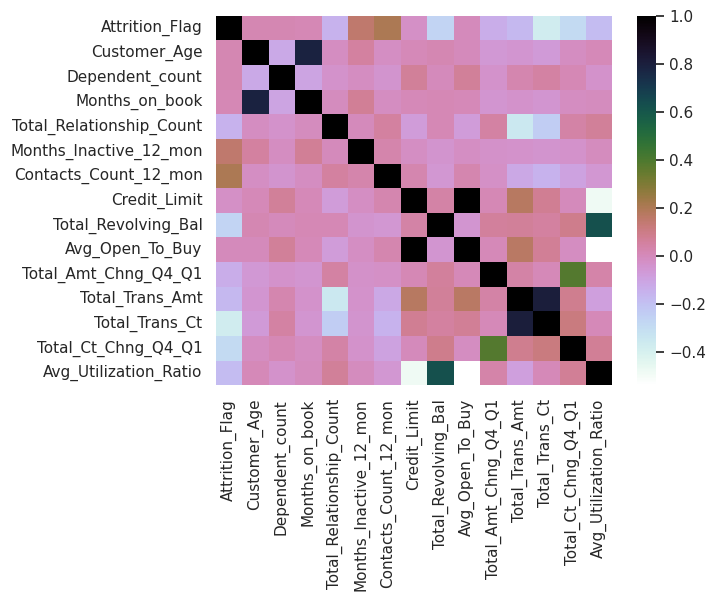

In [62]:
#plotting the correlation matrix
sns.heatmap(credit_df[num_2].corr() ,cmap='cubehelix_r')

### correlation table
For a clearer view a correlation table is reccomended here

In [66]:
#correlation table
corr = credit_df[num_2].corr()
corr.style.background_gradient(cmap='viridis')

,Attrition_Flag,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
Attrition_Flag,1.000000,0.018203,0.018991,0.013687,-0.150005,0.152449,0.204491,-0.023873,-0.263053,-0.000285,-0.131063,-0.168598,-0.371403,-0.290054,-0.178410
Customer_Age,0.018203,1.000000,-0.122254,0.788912,-0.010931,0.054361,-0.018452,0.002476,0.014780,0.001151,-0.062042,-0.046446,-0.067097,-0.012143,0.007114
Dependent_count,0.018991,-0.122254,1.000000,-0.103062,-0.039076,-0.010768,-0.040505,0.068065,-0.002688,0.068291,-0.035439,0.025046,0.049912,0.011087,-0.037135
Months_on_book,0.013687,0.788912,-0.103062,1.000000,-0.009203,0.074164,-0.010774,0.007507,0.008623,0.006732,-0.048959,-0.038591,-0.049819,-0.014072,-0.007541
Total_Relationship_Count,-0.150005,-0.010931,-0.039076,-0.009203,1.000000,-0.003675,0.055203,-0.071386,0.013726,-0.072601,0.050119,-0.347229,-0.241891,0.040831,0.067663
Months_Inactive_12_mon,0.152449,0.054361,-0.010768,0.074164,-0.003675,1.000000,0.029493,-0.020394,-0.042210,-0.016605,-0.032247,-0.036982,-0.042787,-0.038989,-0.007503
Contacts_Count_12_mon,0.204491,-0.018452,-0.040505,-0.010774,0.055203,0.029493,1.000000,0.020817,-0.053913,0.025646,-0.024445,-0.112774,-0.152213,-0.094997,-0.055471
Credit_Limit,-0.023873,0.002476,0.068065,0.007507,-0.071386,-0.020394,0.020817,1.000000,0.042493,0.995981,0.012813,0.171730,0.075927,-0.002020,-0.482965
Total_Revolving_Bal,-0.263053,0.014780,-0.002688,0.008623,0.013726,-0.042210,-0.053913,0.042493,1.000000,-0.047167,0.058174,0.064370,0.056060,0.089861,0.624022
Avg_Open_To_Buy,-0.000285,0.001151,0.068291,0.006732,-0.072601,-0.016605,0.025646,0.995981,-0.047167,1.000000,0.007595,0.165923,0.070885,-0.010076,-0.538808


Now back to our categorical variables:

The decision was to drop `Gender`, `Marital_Status` and `Inocome_Category` that showed no real connection.

In [67]:
credit_df  = credit_df.drop(['Gender', 'Marital_Status','Income_Category'],axis=1)
credit_df.shape

(10127, 17)

### One Hot encoding
Now for the other categorical columns we will use one hot encoding:

In [81]:
#one hot encoding
cols =  credit_df.select_dtypes('object').columns.to_list()
# Apply one-hot encoder
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
credit_oh = pd.DataFrame(OH_encoder.fit_transform(credit_df[cols])).astype('int64')



#get feature columns
credit_oh.columns = OH_encoder.get_feature_names_out(cols)

# One-hot encoding removed index; put it back
credit_oh.index = credit_df.index

# Add one-hot encoded columns to our main df new name: credit_fe (means feature engeenired)
credit_fe = pd.concat([credit_df, credit_oh], axis=1)


In [82]:
# Dropping irrelevant columns
credit_fe = credit_fe.drop(cols,axis=1)

In [83]:
credit_fe.head()

,Attrition_Flag,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,...,Education_Level_College,Education_Level_Doctorate,Education_Level_Graduate,Education_Level_High School,Education_Level_Post-Graduate,Education_Level_Uneducated,Card_Category_Blue,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver
0,0,45,3,39,5,1,3,12691.0,777,11914.0,...,0,0,0,1,0,0,1,0,0,0
1,0,49,5,44,6,1,2,8256.0,864,7392.0,...,0,0,1,0,0,0,1,0,0,0
2,0,51,3,36,4,1,0,3418.0,0,3418.0,...,0,0,1,0,0,0,1,0,0,0
3,0,40,4,34,3,4,1,3313.0,2517,796.0,...,0,0,0,1,0,0,1,0,0,0
4,0,40,3,21,5,1,0,4716.0,0,4716.0,...,0,0,0,0,0,1,1,0,0,0


In [84]:
credit_fe.shape

(10127, 25)

The main interest of the categoric variables is only if the client had a platinum card (showed 25% attrition rate) or if he has Doctorate Education Level (21% Attrition rate) so we drop the rest

In [85]:
# Dropping irrelevant columns
delete = ['Education_Level_College','Education_Level_Graduate','Education_Level_High School','Education_Level_Post-Graduate','Education_Level_Uneducated','Card_Category_Blue','Card_Category_Gold','Card_Category_Silver']
credit_fe = credit_fe.drop(delete,axis=1)
credit_fe.head()

,Attrition_Flag,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Education_Level_Doctorate,Card_Category_Platinum
0,0,45,3,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0,0
1,0,49,5,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0,0
2,0,51,3,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0,0
3,0,40,4,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0,0
4,0,40,3,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0,0


In [90]:
credit_fe.shape

(10127, 12)

Finally we want to get rid of the columns with the weakest correlation.

In [89]:
# Dropping weakest correlation columns
delete2 = ['Customer_Age','Dependent_count','Months_on_book','Credit_Limit','Avg_Open_To_Buy']
credit_fe = credit_fe.drop(delete2,axis=1)
credit_fe.head()

KeyError: "['Customer_Age', 'Dependent_count', 'Months_on_book', 'Credit_Limit', 'Avg_Open_To_Buy'] not found in axis"

This concluds our feature engineering we now have the Attrition flag column and 11 independant variables.

# Machine learning models

![](https://cdn.dribbble.com/users/190345/screenshots/6540623/machinelearning-illustration.gif)
First of all we will divide our dataset into two variables X as the features we defined earlier and y as the Item_ `Attrition_Flag` the target value we want to predict.

### Assumptions:

* This is a classifiction problem so we will use Clustering methods.

* Train test split will be a 8:2 ratio respectively.

### Models we will use:

1. K Nearest Neighbors
2. Decision Tree
3. Random Forest
4. XGBoost
5. Naive Bayes

### The Process of Modeling the Data:

1. Importing the model

2. Fitting the model

3. Predicting Loan Status

4. Classification metrics.

## Note 📝

our ai is to find attrited customrs so we need a model that can identify the most TP out of all the posititives.

In [92]:
y = credit_fe['Attrition_Flag']
X = credit_fe.drop('Attrition_Flag', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.8, random_state = 0)

## KNN

![](https://machinelearningknowledge.ai/wp-content/uploads/2018/08/Value-of-K.gif)



In [95]:
#model
KNN = KNeighborsClassifier(n_neighbors = 7)
#fit
KNN.fit(X_train, y_train)

#predict
y_predict = KNN.predict(X_test)

# confution matrix
print(f"Confution Matrix:\n\n")
print(confusion_matrix(y_test, y_predict))

#  prediction Summary
print(f"prediction Summary:\n\n")
print(classification_report(y_test, y_predict))

# Accuracy score
print(f"Accuracy score:\n\n")
KNN_SC = recall_score(y_test,y_predict)
print(f"we have identified succesfully {round(KNN_SC*100,2)}% of  all Attrited customers")

Confution Matrix:


[[6431  374]
 [ 460  837]]
prediction Summary:


              precision    recall  f1-score   support

           0       0.93      0.95      0.94      6805
           1       0.69      0.65      0.67      1297

    accuracy                           0.90      8102
   macro avg       0.81      0.80      0.80      8102
weighted avg       0.89      0.90      0.90      8102

Accuracy score:


we have identified succesfully 64.53% of  all Attrited customers


## Decision Tree

![](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcT7xJNKjwAixUHk9ESYhA4hcUZCcMfwBIYEkg&usqp=CAU)


In [97]:
DT = DecisionTreeClassifier()
DT.fit(X_train, y_train)

y_predict = DT.predict(X_test)

# confution matrix
print(f"Confution Matrix:\n\n")
print(confusion_matrix(y_test, y_predict))

#  prediction Summary
print(f"rediction Summary :\n\n")
print(classification_report(y_test, y_predict))

# Accuracy score
print(f"Accuracy score:\n\n")
DT_SC = recall_score(y_test,y_predict)
print(f"we have identified succesfully {round(KNN_SC*100,2)}% of  all Attrited customers")

Confution Matrix:


[[6465  340]
 [ 254 1043]]
rediction Summary :


              precision    recall  f1-score   support

           0       0.96      0.95      0.96      6805
           1       0.75      0.80      0.78      1297

    accuracy                           0.93      8102
   macro avg       0.86      0.88      0.87      8102
weighted avg       0.93      0.93      0.93      8102

Accuracy score:


we have identified succesfully 64.53% of  all Attrited customers


## Random Forest

![](https://opendatascience.com/wp-content/uploads/2018/04/Random-Forest-Introduction.jpg)

In [98]:
RF = RandomForestClassifier()
RF.fit(X_train, y_train)

y_predict = RF.predict(X_test)

# confution matrix
print(f"Confution Matrix:\n\n")
print(confusion_matrix(y_test, y_predict))

#  prediction Summary
print(classification_report(y_test, y_predict))

# Accuracy score
RF_SC = recall_score(y_test,y_predict)
print(f"we have identified succesfully {round(RF_SC*100,2)}% of  all Attrited customers")

Confution Matrix:


[[6661  144]
 [ 268 1029]]
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      6805
           1       0.88      0.79      0.83      1297

    accuracy                           0.95      8102
   macro avg       0.92      0.89      0.90      8102
weighted avg       0.95      0.95      0.95      8102

we have identified succesfully 79.34% of  all Attrited customers


## XGBoost

![](https://lstmemery.github.io/images/gradient_descent.gif)

In [99]:
XGB = XGBClassifier()
XGB.fit(X_train, y_train)

y_predict = XGB.predict(X_test)

# confution matrix
print(f"Confution Matrix:\n\n")
print(confusion_matrix(y_test, y_predict))

#  prediction Summary
print(classification_report(y_test, y_predict))

# Accuracy score
XGB_SC = recall_score(y_test,y_predict)
print(f"we have identified succesfully {round(XGB_SC*100,2)}% of  all Attrited customers")

Confution Matrix:


[[6658  147]
 [ 206 1091]]
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      6805
           1       0.88      0.84      0.86      1297

    accuracy                           0.96      8102
   macro avg       0.93      0.91      0.92      8102
weighted avg       0.96      0.96      0.96      8102

we have identified succesfully 84.12% of  all Attrited customers


## Naive Bayse

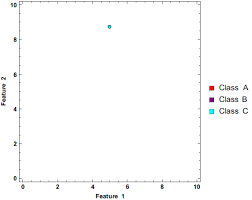

In [100]:
NB = GaussianNB()
NB.fit(X_train, y_train)

y_predict = NB.predict(X_test)

# confution matrix
print(f"Confution Matrix:\n\n")
print(confusion_matrix(y_test, y_predict))

#  prediction Summary
print(classification_report(y_test, y_predict))

# Accuracy score
NB_SC = recall_score(y_test,y_predict)
print(f"we have identified succesfully {round(NB_SC*100,2)}% of  all Attrited customers")

Confution Matrix:


[[6277  528]
 [ 447  850]]
              precision    recall  f1-score   support

           0       0.93      0.92      0.93      6805
           1       0.62      0.66      0.64      1297

    accuracy                           0.88      8102
   macro avg       0.78      0.79      0.78      8102
weighted avg       0.88      0.88      0.88      8102

we have identified succesfully 65.54% of  all Attrited customers


# Conclusion:

In [101]:
#list the model scores
scores = [KNN_SC,DT_SC,RF_SC,XGB_SC,NB_SC]
#make a percentage scake
scores = [round(score*100,2) for score in scores]
#Score data frame
Models = pd.DataFrame({
    'Model': ["K Nearest Neighbors","Decision Tree","Random Forest","XGBoost", "Naive Bayes"],
    'Score (%)': scores})
Models.sort_values(by='Score (%)', ascending=False)

,Model,Score (%)
3,XGBoost,84.12
1,Decision Tree,80.42
2,Random Forest,79.34
4,Naive Bayes,65.54
0,K Nearest Neighbors,64.53


Our XGBoost model reached a recall of **84.58%** therefor he is the prefered model to identify customers with high risk of churning.

<h2 style='text-align:left;font-family:Comic Sans MS;font-size:40px;background-color:white;border:20px;color:black'>If you liked this notebook feel free to upvote!<h2>

![](https://psychicpostpirate.files.wordpress.com/2016/04/87736-anime-finger-gun-upvote-gif-im-rl3i.gif)
    
<h2 style='text-align:center;font-family:Comic Sans MS;font-size:60px;background-color:white;border:20px;color:black'>Coming soon: Cross validation and Gridsearch for XGBoost 🐱‍🏍<h2>